<div align="center"> 

# **"From K-Means Clustering to DBScan Clustering"**

</div>

<div align="justify"> 

### **Load the Dataset**
- **Load CSV File**: Reads the dataset from "../Dataset/ExamplePats.csv".
- **Convert Date Column**: Converts the eksd column (prescription date) to datetime format.

</div>

In [83]:
import pandas as pd
import matplotlib as plt

data = pd.read_csv("../Dataset/ExamplePats.csv")

data.head()

,pnr,eksd,perday,ATC,dur_original
0,1,2033-04-26,4,medA,50
1,1,2033-07-04,4,medB,30
2,1,2033-08-03,4,medB,30
3,1,2033-08-17,4,medB,30
4,1,2033-10-13,4,medB,30


<div align="justify"> 

### **Compute Event Intervals**

The function compute_event_intervals(drug_code, data) calculates the time gaps between successive prescriptions for a specific drug:
- Filters data for a specific medication (ATC column)
- Sorts by patient ID (pnr) and prescription date (eksd)
- Computes the difference (event_interval) in days between successive prescriptions
- Removes non-positive intervals.

Computes event intervals separately for medA and medB.

</div>

<div align="justify"> 

### **Apply DBScan Clustering**

- **Standardizes Data**: Scales event_interval using StandardScaler()
- **Applies DBSCAN**: Clusters event intervals with DBSCAN(eps=0.5, min_samples=5)
- **Plots Clusters**: Uses Seaborn's scatter plot to visualize clusters.

</div>

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Convert prescription date column to datetime
data['eksd'] = pd.to_datetime(data['eksd'])

def compute_event_intervals(drug_code, data):
    drug_data = data[data['ATC'] == drug_code].copy()
    drug_data = drug_data.sort_values(by=['pnr', 'eksd'])
    drug_data['prev_eksd'] = drug_data.groupby('pnr')['eksd'].shift(1)
    drug_data = drug_data.dropna(subset=['prev_eksd'])
    drug_data['event_interval'] = (drug_data['eksd'] - drug_data['prev_eksd']).dt.days
    drug_data = drug_data[drug_data['event_interval'] > 0]  # Remove non-positive intervals
    return drug_data

def plot_density(ax, data, title):
    sns.kdeplot(data, fill=True, ax=ax)
    ax.set_xlabel("Event Interval (days)")
    ax.set_ylabel("Density")
    ax.set_title(title)

def plot_ecdf(ax, data, percentile, title):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    cutoff_index = int(len(x) * (percentile / 100))
    ax.plot(x[:cutoff_index], y[:cutoff_index], marker='.', linestyle='none')
    ax.set_xlabel("Event Interval (days)")
    ax.set_ylabel("ECDF")
    ax.set_title(title)

def plot_histogram(ax, data, title):
    sns.histplot(data, bins=20, kde=True, ax=ax)
    ax.set_xlabel("Event Interval (days)")  # Fixed typo
    ax.set_ylabel("Frequency")
    ax.set_title(title)

# Compute event intervals for all medications
data['prev_eksd'] = data.groupby('pnr')['eksd'].shift(1)
data['event_interval'] = (data['eksd'] - data['prev_eksd']).dt.days
data = data.dropna(subset=['event_interval'])
data = data[data['event_interval'] > 0]  # Remove non-positive intervals

medA_intervals = compute_event_intervals("medA", data)['event_interval']
medB_intervals = compute_event_intervals("medB", data)['event_interval']

# Apply DBSCAN clustering
scaler = StandardScaler()
data['scaled_event_interval'] = scaler.fit_transform(data[['event_interval']])
dbscan = DBSCAN(eps=0.5, min_samples=5)
data['cluster'] = dbscan.fit_predict(data[['scaled_event_interval']])

# Plot DBSCAN clusters
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=data.index, y=data['event_interval'], hue=data['cluster'], palette='viridis')
# plt.xlabel("Index")
# plt.ylabel("Event Interval (days)")
# plt.title("DBSCAN Clustering of Event Intervals")
# plt.legend(title="Cluster")
# plt.show()

<div align="justify">

### **Generate and Save Density, ECDF, and Histogram Plots**

- Density Plots (Smooth probability distributions)
- Empirical CDF (ECDF) Plots for 80% and 100% of data
- Histograms (Shows distribution of event intervals)

The General Boxplot of Prescription Duration shows how prescription durations vary by sequence number. Whereas for each drug, medA and medB medians highlights medians. 

The program analyzes prescription patterns by calculating event intervals, clustering patients' prescription behaviors using DBSCAN, and visualizing the data distribution through density plots, ECDF plots, histograms, and boxplots. By identifying patterns and anomalies in prescription habits, this approach can be valuable for medical research, fraud detection, and assessing treatment adherence.

</div>

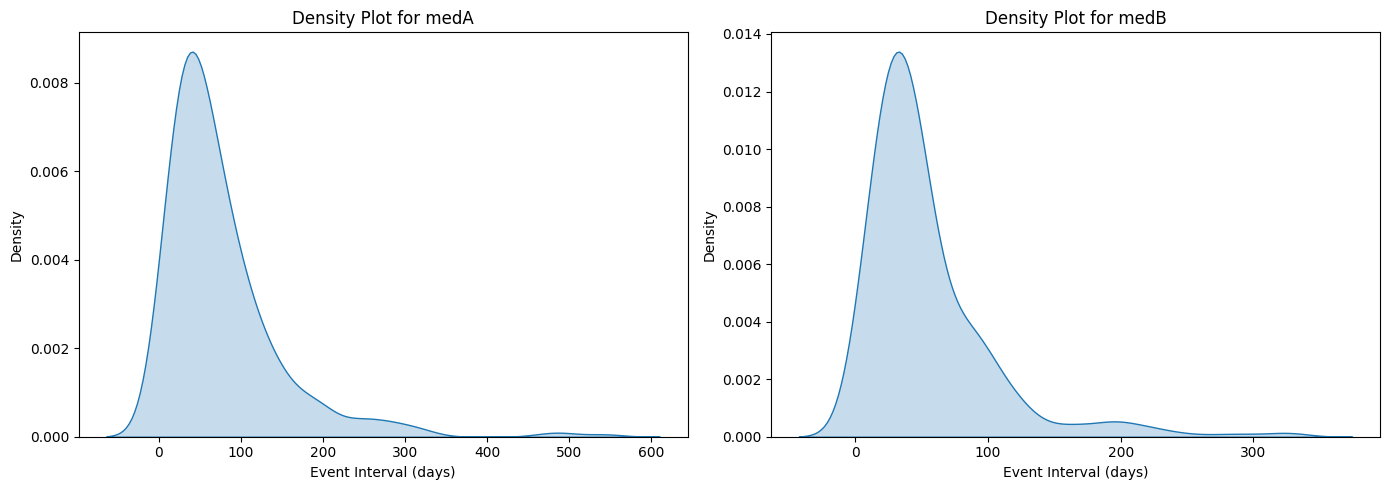

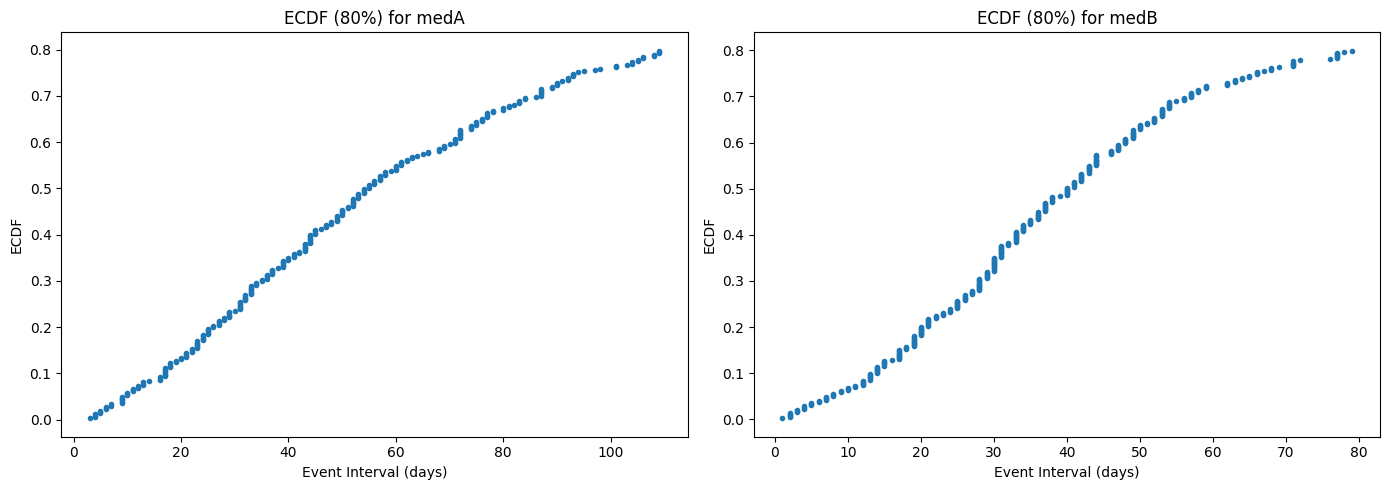

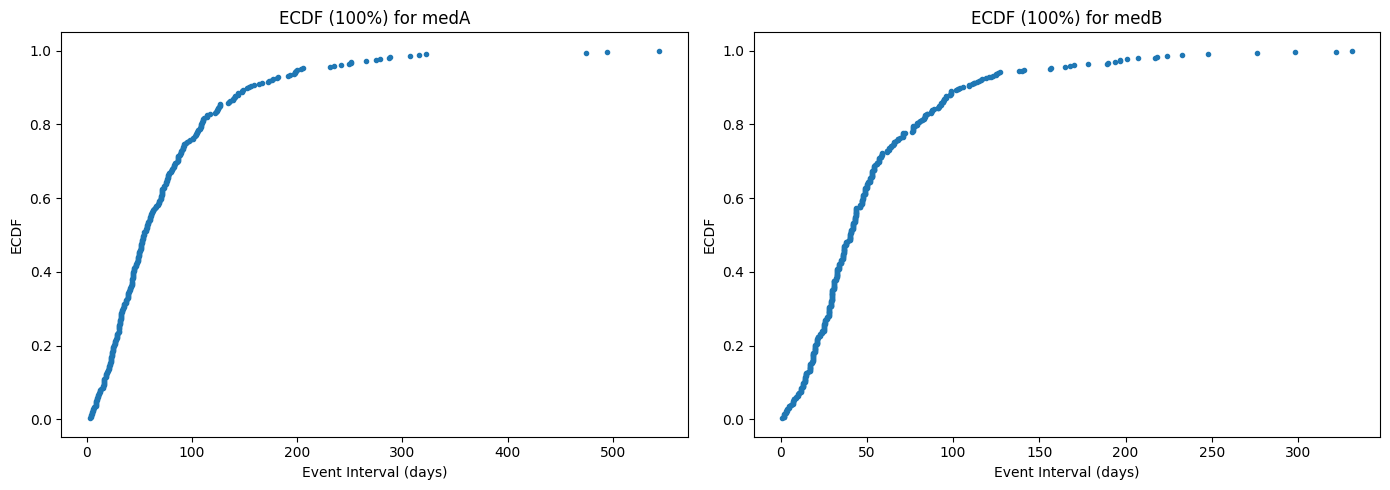

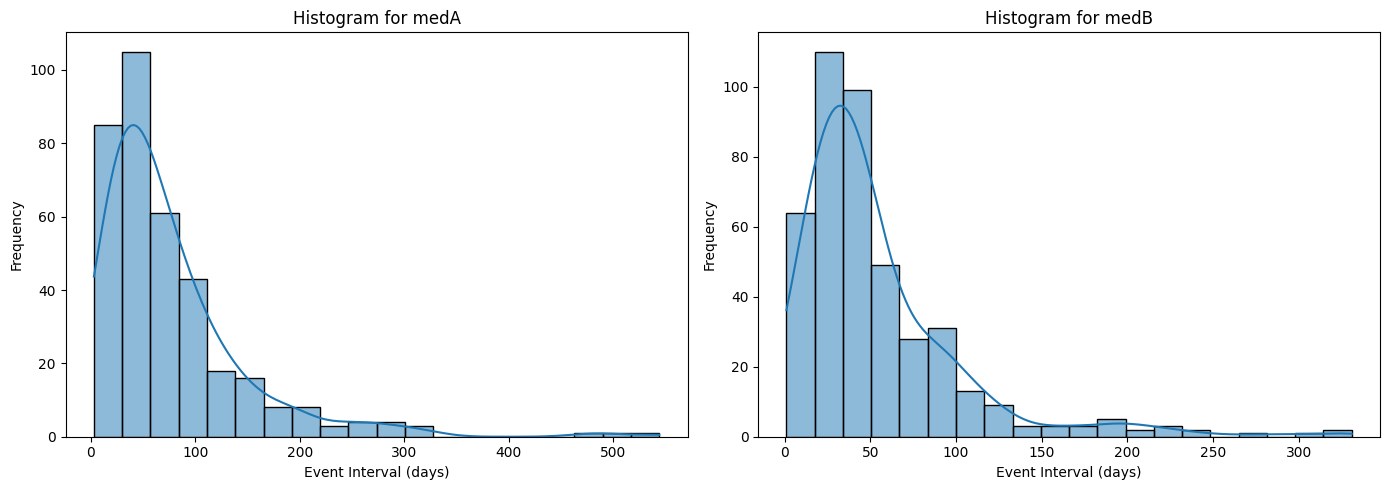

In [85]:
import os

output_dir = "DBScan Charts"
os.makedirs(output_dir, exist_ok=True)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_density(axes[0], medA_intervals, "Density Plot for medA")
plot_density(axes[1], medB_intervals, "Density Plot for medB")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "Density_Plots.png"))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_ecdf(axes[0], medA_intervals, 80, "ECDF (80%) for medA")
plot_ecdf(axes[1], medB_intervals, 80, "ECDF (80%) for medB")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "ECDF_80_Plots.png"))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_ecdf(axes[0], medA_intervals, 100, "ECDF (100%) for medA")
plot_ecdf(axes[1], medB_intervals, 100, "ECDF (100%) for medB")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "ECDF_100_Plots.png"))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_histogram(axes[0], medA_intervals, "Histogram for medA")
plot_histogram(axes[1], medB_intervals, "Histogram for medB")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "Histogram_Plots.png"))
plt.show()

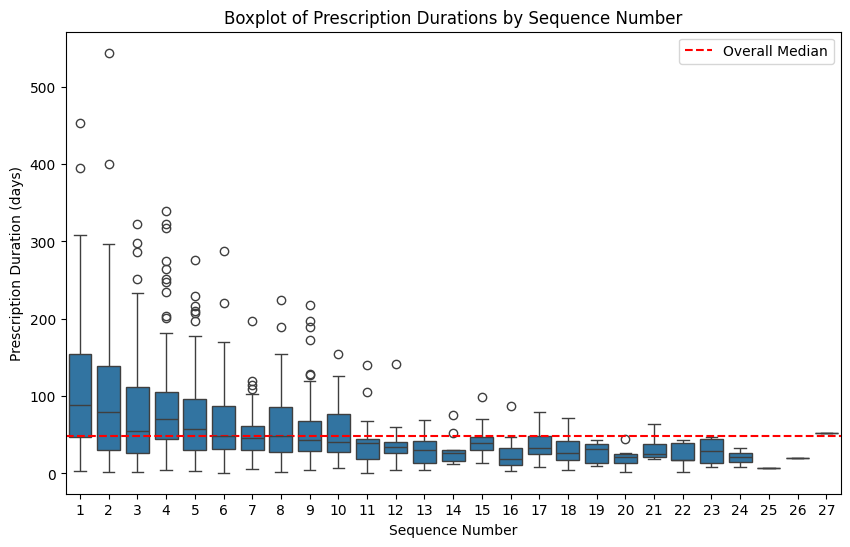

In [86]:
# Create boxplot of prescription durations by sequence number
data['sequence_number'] = data.groupby('pnr').cumcount() + 1
plt.figure(figsize=(10, 6))
sns.boxplot(x='sequence_number', y='event_interval', data=data)
plt.axhline(y=data['event_interval'].median(), color='red', linestyle='--', label='Overall Median')
plt.xlabel("Sequence Number")
plt.ylabel("Prescription Duration (days)")
plt.title("Boxplot of Prescription Durations by Sequence Number")
plt.legend()
plt.show()

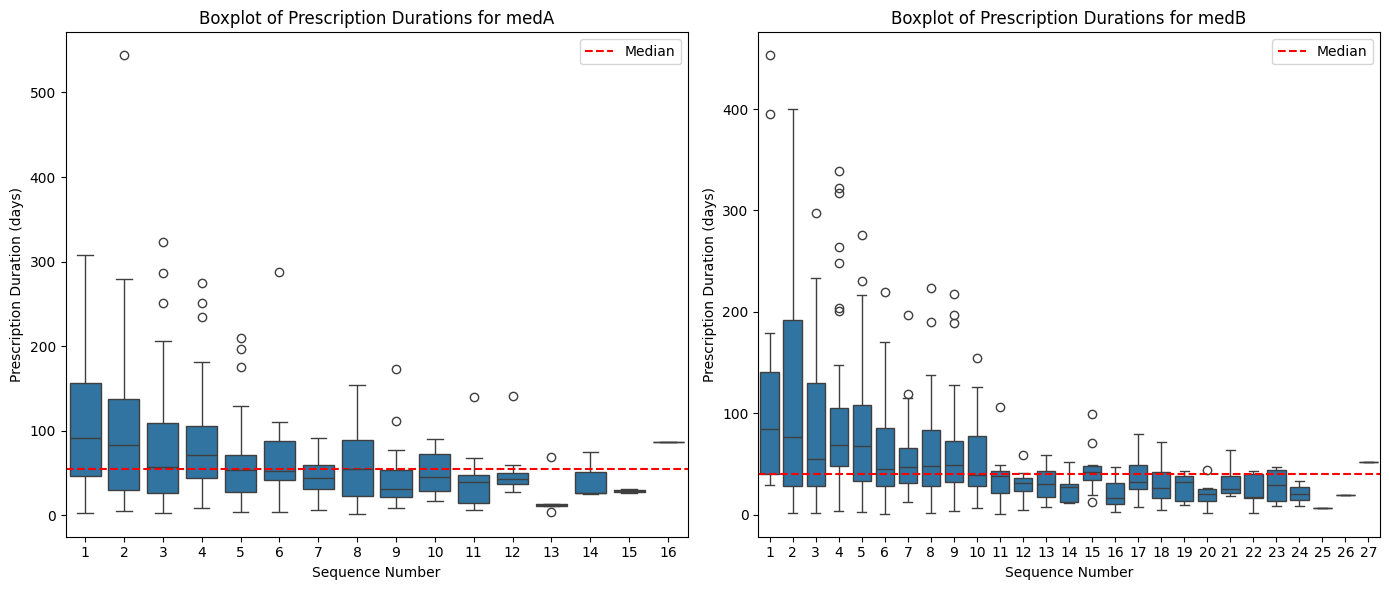

In [87]:
# Create boxplots for medA and medB
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(x='sequence_number', y='event_interval', data=data[data['ATC'] == 'medA'], ax=axes[0])
axes[0].axhline(y=medA_intervals.median(), color='red', linestyle='--', label='Median')
axes[0].set_title("Boxplot of Prescription Durations for medA")
axes[0].set_xlabel("Sequence Number")
axes[0].set_ylabel("Prescription Duration (days)")
axes[0].legend()

sns.boxplot(x='sequence_number', y='event_interval', data=data[data['ATC'] == 'medB'], ax=axes[1])
axes[1].axhline(y=medB_intervals.median(), color='red', linestyle='--', label='Median')
axes[1].set_title("Boxplot of Prescription Durations for medB")
axes[1].set_xlabel("Sequence Number")
axes[1].set_ylabel("Prescription Duration (days)")
axes[1].legend()

plt.tight_layout()
plt.show()